# ML4DD Summer School Hackathon

The final days of the Machine Learning For Drug Discovery summer school ends with a hackathon. We will use Polaris as a tool to get the associated benchmarks and datasets. First things first, we will install Polaris from PyPi.

In [ ]:
!pip install polaris-lib

We next need to authenticate ourselves to Polaris. If you haven't done so yet, you can create an account at https://polarishub.io. Afterwards, you can simply run the command below.

In [ ]:
!polaris login

2024-06-21 13:54:33.611 | INFO     | polaris.hub.client:login:285 - You are already logged in to the Polaris Hub as ranaabarghout (ranamoneim@gmail.com). Set `overwrite=True` to force re-authentication.


In [ ]:
# @title Set an owner

owner = 'rana-barghout' # @param {type:"string"}

print(f"You have set \"{owner}\" as the owner")

You have set "rana-barghout" as the owner


# Kinase Selectivity

The second benchmark we will use is `polaris/pkis1-kit-wt-mut-c-1`. Using this benchmark is very similar to before, except for one difference: This is a multi-task benchmark.

In [ ]:
import polaris as po
import datamol as dm
import numpy as np
import pandas as pd
import pickle
import torch

In [ ]:
benchmark = po.load_benchmark("polaris/pkis1-kit-wt-mut-c-1")
train, test = benchmark.get_train_test_split(featurization_fn=dm.to_fp)
train[0]

2024-06-21 13:54:45.344 | INFO     | polaris._artifact:_validate_version:66 - The version of Polaris that was used to create the artifact (0.0.0) is different from the currently installed version of Polaris (dev).
2024-06-21 13:54:45.351 | INFO     | polaris._artifact:_validate_version:66 - The version of Polaris that was used to create the artifact (0.0.0) is different from the currently installed version of Polaris (dev).


(array([0, 0, 0, ..., 0, 0, 0], dtype=uint8),
 {'CLASS_KIT_(T6701_mutant)': 0.0,
  'CLASS_KIT_(V560G_mutant)': 0.0,
  'CLASS_KIT': 0.0})

As we can see, the targets are now returned to us as a dictionary. Let's train a multi-task model on this data! We first preprocess the data to be in a format we can use with scikit-learn.

In [ ]:
print(test.X.shape)
print(train.X.shape)

(87, 2048)
(277, 2048)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

cd_path = '/content/drive/MyDrive/Colab Notebooks/Rana/ML for Drug Discovery Summer School/Data/'

Mounted at /content/drive


In [ ]:
# Check if CUDA is available and if so, use it
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
mol_embed_train = pd.read_csv(cd_path+"mol_embed_train.csv", header=None).values[:, 1:]
mol_embed_test = pd.read_csv(cd_path+"mol_embed_test.csv", header=None).values[:, 1:]

with open(cd_path+'WT_full.pkl', 'rb') as file:
    wt_embed = pickle.load(file)

with open(cd_path+'KIT_T670I_full.pkl', 'rb') as file:
    t670i_embed = pickle.load(file)

with open(cd_path+'KIT_V560G_full.pkl', 'rb') as file:
    v560g_embed = pickle.load(file)


In [ ]:
mol_embed_train = train.X
mol_embed_test = test.X

In [ ]:
ys = train.y
ys = np.stack([ys[target] for target in benchmark.target_cols], axis=1)
ys[0, :]
ys.shape
mask = ~np.any(np.isnan(ys), axis=1)
mask  = torch.from_numpy(mask)

ys2 = torch.from_numpy(ys)
ys2.shape
train_labels = [ys2[mask][:, 0], ys2[mask][:, 1], ys2[mask][:, 2]]
train_labels_torch = torch.cat(train_labels, dim=0)
# mask = mask.expand(-1, 978, 1280)

# mask.sum()
# mask = ~np.any(np.isnan(ys), axis=1)
# mask = mask.unsqueeze(1)

In [ ]:
wt_embed_train = wt_embed.unsqueeze(0).repeat(mol_embed_train.shape[0], 1, 1)
wt_embed_train = wt_embed_train[mask]
t670i_embed_train = t670i_embed.unsqueeze(0).repeat(mol_embed_train.shape[0], 1, 1)
t670i_embed_train = t670i_embed_train[mask]
v560g_embed_train = v560g_embed.unsqueeze(0).repeat(mol_embed_train.shape[0], 1, 1)
v560g_embed_train = v560g_embed_train[mask]


wt_embed_test = wt_embed.unsqueeze(0).repeat(mol_embed_test.shape[0], 1, 1)
t670i_embed_test = t670i_embed.unsqueeze(0).repeat(mol_embed_test.shape[0], 1, 1)
v560g_embed_test = v560g_embed.unsqueeze(0).repeat(mol_embed_test.shape[0], 1, 1)
print(wt_embed_train.shape)
print(t670i_embed_train.shape)
print(v560g_embed_train.shape)

print(wt_embed_test.shape)
print(t670i_embed_test.shape)
print(v560g_embed_test.shape)


# Assume molecule_df is your DataFrame
mol_embed_train = mol_embed_train.astype(float)
mol_embed_train = torch.tensor(mol_embed_train)
mol_embed_train = mol_embed_train[mask]
print(mol_embed_train.shape)
mol_embed_test = mol_embed_test.astype(float)
mol_embed_test = torch.tensor(mol_embed_test)
print(mol_embed_test.shape)


torch.Size([276, 978, 1280])
torch.Size([276, 978, 1280])
torch.Size([276, 978, 1280])
torch.Size([87, 978, 1280])
torch.Size([87, 978, 1280])
torch.Size([87, 978, 1280])
torch.Size([276, 2048])
torch.Size([87, 2048])


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd

class ProteinMoleculeDataset(Dataset):
    def __init__(self, protein_tensors, molecule_tensors):
        self.protein_tensors = torch.cat(protein_tensors, dim=0)
        self.molecule_tensors = torch.cat(molecule_tensors, dim=0)

    def __len__(self):
        return self.protein_tensors.shape[0]

    def __getitem__(self, idx):
        protein_tensor = self.protein_tensors[idx]
        molecule_tensor = self.molecule_tensors[idx]
        return protein_tensor, molecule_tensor



In [ ]:
class ProteinMoleculeTrainingDataset(Dataset):
    def __init__(self, protein_tensors, molecule_tensors, y_labels):
        self.protein_tensors = torch.cat(protein_tensors, dim=0)
        self.molecule_tensors = torch.cat(molecule_tensors, dim=0)
        self.y_labels = torch.cat(y_labels, dim=0)  # Convert labels to a PyTorch tensor

    def __len__(self):
        return self.protein_tensors.shape[0]

    def __getitem__(self, idx):
        protein_tensor = self.protein_tensors[idx]
        molecule_tensor = self.molecule_tensors[idx]
        y_label = self.y_labels[idx]
        return protein_tensor, molecule_tensor, y_label  # Return label along with data


In [300]:
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import WeightedRandomSampler
# Assume y_labels is a list or array of your labels
y_labels = train_labels
protein_tensors = [wt_embed_train, t670i_embed_train, v560g_embed_train]
molecule_tensors = [mol_embed_train, mol_embed_train, mol_embed_train]

dataset = ProteinMoleculeTrainingDataset(protein_tensors, molecule_tensors, y_labels)
train_labels_torch = dataset.y_labels

# Calculate class weights
class_sample_counts = torch.tensor([(train_labels_torch == t).sum() for t in torch.unique(train_labels_torch, sorted=True)])
class_weights = 1. / class_sample_counts.float()

# Make sure to convert the labels to long type explicitly for indexing
sample_weights = torch.tensor([class_weights[t.long()].item() for t in train_labels_torch])

# Create the weighted sampler
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

# Create the DataLoader with the weighted sampler
dataloader = DataLoader(dataset, batch_size=128, sampler=sampler)

# Verify DataLoader
for batch in dataloader:
    protein_tensors_batch, molecule_tensors_batch, y_labels_batch = batch
    print(y_labels_batch)
    # Ensure you check the distribution of labels to confirm the balancing
    break


tensor([0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0.,
        1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 0.,
        1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1.,
        0., 1., 1., 1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0.,
        0., 1., 1., 1., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 1., 1.,
        1., 1., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0.,
        0., 1., 0., 0., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.], dtype=torch.float64)


### Original Self-Attention Model

In [301]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SelfAttention(nn.Module):
    def __init__(self, input_dim):
        super(SelfAttention, self).__init__()
        self.query = nn.Linear(input_dim, input_dim)
        self.key = nn.Linear(input_dim, input_dim)
        self.value = nn.Linear(input_dim, input_dim)

    def forward(self, x):
        q = self.query(x)
        k = self.key(x)
        v = self.value(x)
        attn_weights = F.softmax(q @ k.transpose(-2, -1), dim=-1)
        output = attn_weights @ v
        return output.sum(dim=1)  # Sum over the sequence dimension

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.protein_attention = SelfAttention(1280)
        # self.molecule_fc = nn.Linear(384, 1280)
        self.protein_fc = nn.Linear(1280, 664)
        self.fc1 = nn.Linear(2048, 1280)
        self.fc2 = nn.Linear(1280, 664)
        self.fc3 = nn.Linear(664, 128)
        self.fc4 = nn.Linear(128, 1)

    def forward(self, protein_data, molecule_data):
        protein_data = self.protein_attention(protein_data.float())
        protein_data = self.protein_fc(protein_data)
        # molecule_data = F.relu(self.molecule_fc(molecule_data.float()))
        molecule_data = molecule_data.float()
        x = protein_data + molecule_data
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        return x

### Self-Attention + Cross-Attention

In [302]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SelfAttention(nn.Module):
    def __init__(self, input_dim):
        super(SelfAttention, self).__init__()
        self.query = nn.Linear(input_dim, input_dim)
        self.key = nn.Linear(input_dim, input_dim)
        self.value = nn.Linear(input_dim, input_dim)

    def forward(self, x):
        q = self.query(x)
        k = self.key(x)
        v = self.value(x)
        attn_weights = F.softmax(q @ k.transpose(-2, -1), dim=-1)
        output = attn_weights @ v
        return output.sum(dim=1)  # Sum over the sequence dimension

class CrossAttention(nn.Module):
    def __init__(self, input_dim):
        super(CrossAttention, self).__init__()
        self.query = nn.Linear(input_dim, input_dim)
        self.key = nn.Linear(input_dim, input_dim)
        self.value = nn.Linear(input_dim, input_dim)

    def forward(self, q, k, v):
        q = self.query(q)
        k = self.key(k)
        v = self.value(v)
        attn_weights = F.softmax(q @ k.transpose(-2, -1), dim=-1)
        output = attn_weights @ v
        return output.sum(dim=1)  # Sum over the sequence dimension

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.protein_attention = SelfAttention(1280)
        self.molecule_fc = nn.Linear(2048, 1280)
        self.cross_attention = CrossAttention(1280)
        self.protein_fc = nn.Linear(1280, 664)
        self.fc1 = nn.Linear(664, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 1)

    def forward(self, protein_data, molecule_data):
        # Compute differences between protein embeddings
        protein_diffs = protein_data[:, 1:, :] - protein_data[:, :-1, :]

        # Apply self-attention to the differences
        protein_diffs_attended = self.protein_attention(protein_diffs.float())

        # Project molecule data to the same dimension as protein data
        molecule_data = F.relu(self.molecule_fc(molecule_data.float()))

        # Cross-attention between protein and molecule data
        protein_diffs_expanded = protein_diffs_attended.unsqueeze(1)
        molecule_data_expanded = molecule_data.unsqueeze(1)
        cross_attended_data = self.cross_attention(protein_diffs_expanded, molecule_data_expanded, molecule_data_expanded)

        # Combine the cross-attended data with the protein data
        combined_data = protein_diffs_attended + cross_attended_data.squeeze(1)
        combined_data = self.protein_fc(combined_data)

        # Pass through fully connected layers
        x = F.relu(self.fc1(combined_data))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        return x



## Training Loop

Finished Training


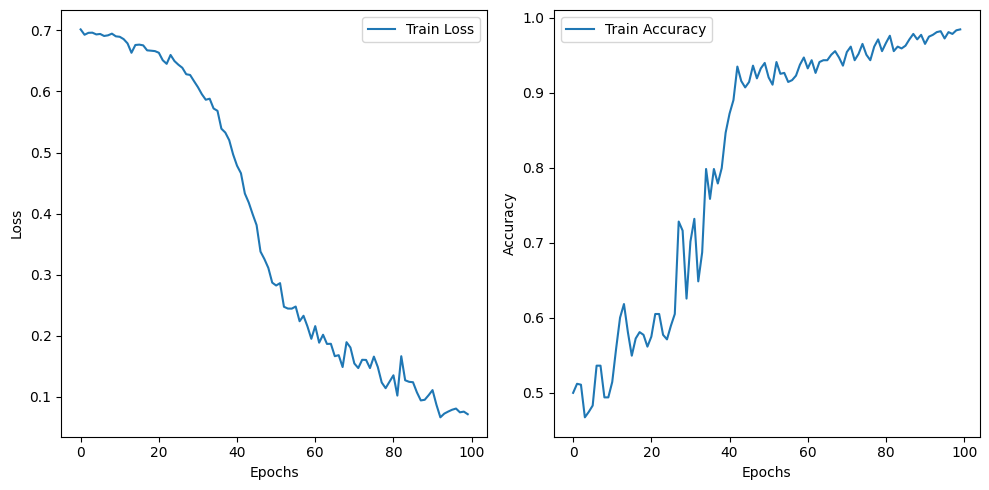

In [338]:
import matplotlib.pyplot as plt

# Instantiate the model
model = Net()
model = model.to('cuda')  # If you're using a GPU

# Define a loss function and optimizer
criterion = nn.BCELoss()  # Binary cross entropy loss for binary classification
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

# Number of epochs to train for
num_epochs = 100

# Lists to store loss and accuracy values
loss_values = []
accuracy_values = []

# Training loop
for epoch in range(num_epochs):
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    for i, data in enumerate(dataloader, 0):
        # Get the inputs; data is a list of [inputs, labels]
        protein_data, molecule_data, labels = data
        protein_data = protein_data.to('cuda')  # If you're using a GPU
        molecule_data = molecule_data.to('cuda')  # If you're using a GPU
        labels = labels.to('cuda')  # If you're using a GPU

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(protein_data, molecule_data)
        outputs = outputs.squeeze(1)
        loss = criterion(outputs.float(), labels.float())

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Calculate accuracy
        predictions = (outputs > 0.5).float()
        correct_predictions += (predictions == labels).sum().item()
        total_predictions += labels.numel()

        # Print statistics
        running_loss += loss.item()
        if i % 1000 == 999:  # Print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

    # Store loss and accuracy values
    loss_values.append(running_loss / len(dataloader))
    accuracy_values.append(correct_predictions / total_predictions)

print('Finished Training')

# Plot loss curve
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(loss_values, label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy curve
plt.subplot(1, 2, 2)
plt.plot(accuracy_values, label='Train Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [339]:
# Assume protein_tensors is a list of your protein tensors and molecule_dfs is a list of your molecule dataframes
protein_tensors_test = [t670i_embed_test, v560g_embed_test, wt_embed_test]
molecule_tensors_test = [mol_embed_test, mol_embed_test, mol_embed_test]

test_dataset = ProteinMoleculeDataset(protein_tensors_test, molecule_tensors_test)
test_dataloader = DataLoader(test_dataset, batch_size=261, shuffle=False)

In [340]:
# Get probabilities for the test set
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for i, test_data in enumerate(test_dataloader, 0):
            # Get the inputs; data is a list of [inputs, labels]
            protein_data, molecule_data = test_data
            protein_data = protein_data.to('cuda')  # If you're using a GPU
            molecule_data = molecule_data.to('cuda')  # If you're using a GPU
            test_outputs = model(protein_data, molecule_data)

# Convert the probabilities to a 2-column array
probabilities = torch.stack([1 - test_outputs, test_outputs], dim=1)
probabilities = probabilities.squeeze(-1)

y_pred = (test_outputs > 0.5).float()

In [341]:
probabilities.shape
# Move the tensor back to the CPU
probabilities = probabilities.cpu()

# Convert the tensor to a numpy array
probabilities_numpy = probabilities.detach().numpy()

y_pred = y_pred.cpu()
y_pred = y_pred.detach().numpy()

test_outputs = test_outputs.cpu()
test_outputs_numpy = test_outputs.detach().numpy()

In [342]:
test_outputs.shape

torch.Size([261, 1])

In [343]:
y_pred = {'CLASS_KIT_(T6701_mutant)': y_pred[:87], 'CLASS_KIT_(V560G_mutant)': y_pred[87:174], 'CLASS_KIT': y_pred[174:]}

In [344]:
len(y_pred)

3

In [345]:
y_prob = {'CLASS_KIT_(T6701_mutant)': probabilities_numpy[:87, 1], 'CLASS_KIT_(V560G_mutant)': probabilities_numpy[87:174, 1], 'CLASS_KIT': probabilities_numpy[174:, 1]}

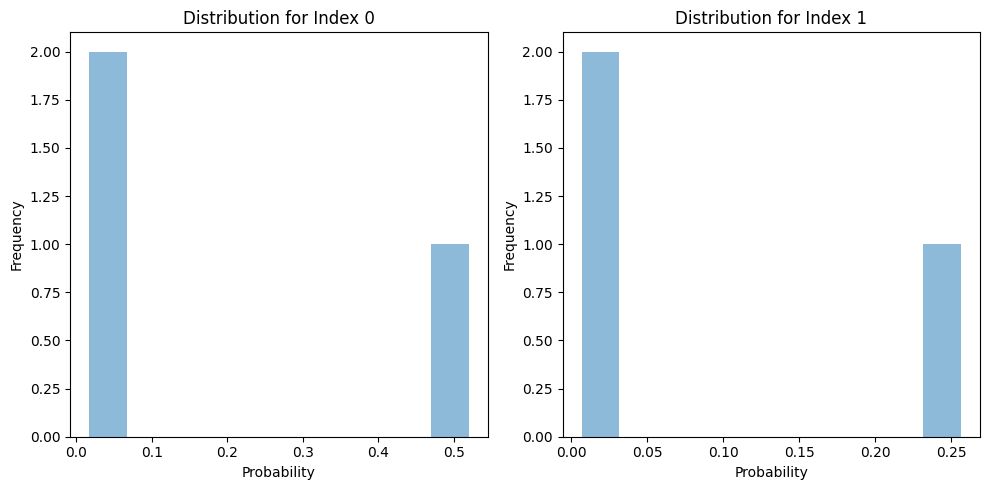

In [346]:
# Create a new figure
plt.figure(figsize=(10, 5))

# Plot histogram for index 0
plt.subplot(1, 2, 1)
plt.hist([y_prob[key][0] for key in y_prob.keys()], bins=10, alpha=0.5)
plt.title('Distribution for Index 0')
plt.xlabel('Probability')
plt.ylabel('Frequency')

# Plot histogram for index 1
plt.subplot(1, 2, 2)
plt.hist([y_prob[key][1] for key in y_prob.keys()], bins=10, alpha=0.5)
plt.title('Distribution for Index 1')
plt.xlabel('Probability')
plt.ylabel('Frequency')

# Show the plot
plt.tight_layout()
plt.show()

In [347]:
results = benchmark.evaluate(y_pred=y_pred, y_prob=y_prob)

In [348]:
benchmark.evaluate(y_pred=y_pred, y_prob=y_prob)

{
  "name": null,
  "description": "",
  "tags": [],
  "user_attributes": {},
  "owner": null,
  "polaris_version": "dev",
  "benchmark_name": "pkis1-kit-wt-mut-c-1",
  "benchmark_owner": {
    "slug": "polaris",
    "external_id": "org_2gtoaJIVrgRqiIR8Qm5BnpFCbxu",
    "type": "organization"
  },
  "github_url": null,
  "paper_url": null,
  "contributors": null,
  "artifact_id": null,
  "benchmark_artifact_id": "polaris/pkis1-kit-wt-mut-c-1",
  "results": [
    {
      "Test set": "test",
      "Target label": "CLASS_KIT_(T6701_mutant)",
      "Metric": "accuracy",
      "Score": 0.8390804598
    },
    {
      "Test set": "test",
      "Target label": "CLASS_KIT_(V560G_mutant)",
      "Metric": "accuracy",
      "Score": 0.7471264368
    },
    {
      "Test set": "test",
      "Target label": "CLASS_KIT",
      "Metric": "accuracy",
      "Score": 0.6436781609
    },
    {
      "Test set": "test",
      "Target label": "CLASS_KIT_(T6701_mutant)",
      "Metric": "f1",
      "Score": 0.125
    },
    {
      "Test set": "test",
      "Target label": "CLASS_KIT_(V560G_mutant)",
      "Metric": "f1",
      "Score": 0.4210526316
    },
    {
      "Test set": "test",
      "Target label": "CLASS_KIT",
      "Metric": "f1",
      "Score": 0.1142857143
    },
    {
      "Test set": "test",
      "Target label": "CLASS_KIT_(T6701_mutant)",
      "Metric": "roc_auc",
      "Score": 0.8600782779
    },
    {
      "Test set": "test",
      "Target label": "CLASS_KIT_(V560G_mutant)",
      "Metric": "roc_auc",
      "Score": 0.8466666667
    },
    {
      "Test set": "test",
      "Target label": "CLASS_KIT",
      "Metric": "roc_auc",
      "Score": 0.8496071829
    },
    {
      "Test set": "test",
      "Target label": "CLASS_KIT_(T6701_mutant)",
      "Metric": "pr_auc",
      "Score": 0.6025512714
    },
    {
      "Test set": "test",
      "Target label": "CLASS_KIT_(V560G_mutant)",
      "Metric": "pr_auc",
      "Score": 0.6360278146
    },
    {
      "Test set": "test",
      "Target label": "CLASS_KIT",
      "Metric": "pr_auc",
      "Score": 0.7792089956
    },
    {
      "Test set": "test",
      "Target label": "CLASS_KIT_(T6701_mutant)",
      "Metric": "mcc",
      "Score": 0.1415474673
    },
    {
      "Test set": "test",
      "Target label": "CLASS_KIT_(V560G_mutant)",
      "Metric": "mcc",
      "Score": 0.321409255
    },
    {
      "Test set": "test",
      "Target label": "CLASS_KIT",
      "Metric": "mcc",
      "Score": 0.1962209821
    },
    {
      "Test set": "test",
      "Target label": "CLASS_KIT_(T6701_mutant)",
      "Metric": "cohen_kappa",
      "Score": 0.0883233533
    },
    {
      "Test set": "test",
      "Target label": "CLASS_KIT_(V560G_mutant)",
      "Metric": "cohen_kappa",
      "Score": 0.2863534676
    },
    {
      "Test set": "test",
      "Target label": "CLASS_KIT",
      "Metric": "cohen_kappa",
      "Score": 0.0741503605
    }
  ]
}

In [349]:
results.name = "Rana-SelfCrossAtt-result9"
results.description = "ECFP_ESM2_SelfCrossAtt-focusedattention"

In [350]:
# A link to your code, e.g. Github or Google Colab.
results.github_url = "https://github.com/ranaabarghout/MLDD_Hackathon/blob/main/ML4DD_Summer_School_Hackathon_V2Rana.ipynb"

# A link to a short (<1 page) write-up of your method
# e.g. in Google Docs or Notion
results.paper_url = "https://docs.google.com/document/d/1mrmfdBFFn-xHRNjXnTjyLrFg9JzJse4AGFqdqvJNCvQ/edit?usp=sharing"

# Specify the username of all your team members
results.contributors = ["rana-barghout"]

In [351]:
results.upload_to_hub(owner=owner);

2024-06-21 17:47:55.982 | SUCCESS  | polaris.hub.client:upload_results:492 - Your result has been successfully uploaded to the Hub. View it here: https://polarishub.io/benchmarks/polaris/pkis1-kit-wt-mut-c-1/bftE05nrMl5haoFMbeUxh


The End.